# 텔레그램 봇 

# 1. 서비스 범위 계획
 팀 -> 부문(베타버젼) -> 전사(알파버젼) -> 고객서비스)
    
# 2. 서비스 라인업('17/6/28일 기준)
 #1. 당일 마감 시황 (주중 오후 3시 40분)
 #2. 전일 해외지수 : 다우, 나스닥, H, 상해, 니케이 (주중 오전 8시 30분)
 #3. 네이버 종목 실검 순위 (주중 오전 9시 10분)  
 #4. 네이버 뉴스 실검 : (매일 12시 00분)
 #5. 날씨 : (매일 8시 00분)
 #6. 영화박스오피스 : (금요일 13시 00분)
 #7. 명언 : (월요일 7시 50분)
 
# 참고 
- 텔레그램 봇 파이썬 연동 방법 :  https://blog.psangwoo.com/coding/2016/12/08/python-telegram-bot-1.html
- 텔레그램 라이브러리 : https://github.com/YoonHanho/python-telegram-bot

In [1]:
# 라이브러리 가져오기
import telepot

from pprint import pprint
from lxml import html, cssselect
from bs4 import BeautifulSoup
import requests

from pandas import DataFrame, Series
from datetime import datetime, timedelta, time

import time as tm # datetime과 라이브러리 이름 겹칩. tm으로 약어 줄 것(sleep 줄 때 씀)

In [2]:
# 봇 호출 및 정보 보기
bot = telepot.Bot('텔레그렘 봇 토큰 번호를 넣으세요') # 봇 토큰 저장
bot.getMe() # 봇 정보 보기

{'first_name': 'wonder_st_bot', 'id': 344624778, 'username': 'wonder_st_bot'}

In [3]:
# 봇에 등록된 최근 메시지 보기
response = bot.getUpdates()
pprint(response)

[{'message': {'chat': {'first_name': '한호',
                       'id': 51088458,
                       'last_name': '윤',
                       'type': 'private'},
              'date': 1498649123,
              'from': {'first_name': '한호',
                       'id': 51088458,
                       'language_code': 'ko-KR',
                       'last_name': '윤'},
              'message_id': 84,
              'text': '좋은 정보 날려줘용'},
  'update_id': 831650192}]


In [4]:
# 봇에서 친구에게 메시지를 보냅니다. 
bot.sendMessage(51088458, '굿모닝~ 좋은 아침')

{'chat': {'first_name': '한호',
  'id': 51088458,
  'last_name': '윤',
  'type': 'private'},
 'date': 1498649197,
 'from': {'first_name': 'wonder_st_bot',
  'id': 344624778,
  'username': 'wonder_st_bot'},
 'message_id': 85,
 'text': '굿모닝~ 좋은 아침'}

# 여기까지가 기본적인 봇 프로그램입니다.
# 등록하고, 메시지 받고, 메시지 보내고~ 엄청 간단하죠? ㅋ

# 아래부터는 여러명으 친구들에게 웹 크롤링한한 결과를 
# 일정표대로 발송하는 예제입니다.
# (웹 크롤링 코드가 상당히 어지럽습니다. 양해 부탁드립니다~!)

In [5]:
# 발송대상자 등록(ID값은 예제)
user_id  = [0000000,111111,3333333,4444444,555555]

In [ ]:
# 7개 주제의 웹 크롤링 코드
# 엄청 깁니다. 생략생략~

# 웹 페이지 크롤링
def url_elem(u):
    url = u
    resp = requests.get(url)
    return html.fromstring(resp.text)

# 특수문제 제거
def special_char_delete(st):
    return st.replace('\t','').replace('\n','').replace('\r',' ').replace('  ','')

# 개별 종목 불러오기
def stock_price(stock_code):
    url = 'http://m.finance.daum.net/m/item/main.daum?code=' + stock_code
    elem = url_elem(url)
    
    price = elem.cssselect('span.price')[0].text_content().strip()  # 주가
    price_gap = elem.cssselect('span.price_fluc')[0].text_content().strip()  # 주가
    price_gap_rate = elem.cssselect('span.rate_fluc')[0].text_content().strip()  # 주가
    return [price, price_gap, price_gap_rate]


#1. 당일 마감지수 : 코스피/코스닥/미래에셋대우 (주중 오후 3시 40분)
def close_msg():
    elem = url_elem('http://finance.naver.com/sise/')

    lst = []
    for i in elem.cssselect('span#KOSPI_now.num'):  
        lst.append(i.text_content().strip())
        
    for i in elem.cssselect('span#KOSPI_change.num_s'):  
        lst.append(i.text_content().strip())
        
    for i in elem.cssselect('span#KOSDAQ_now.num'):  
        lst.append(i.text_content().strip())
        
    for i in elem.cssselect('span#KOSDAQ_change.num_s'):  
        lst.append(i.text_content().strip())
       
    kospi_close = lst[0]
    kospi_uppct = lst[1].split(' ')[1][:-2]
    if kospi_uppct[0] == '+':
        kospi_upval = '▲' + lst[1].split(' ')[0]
    elif kospi_uppct[0] == '-':
        kospi_upval = '▼' + lst[1].split(' ')[0]
        
    kosdaq_close = lst[2]
    kosdaq_uppct = lst[3].split(' ')[1][:-2]
    if kosdaq_uppct[0] == '+':
        kosdaq_upval = '▲' + lst[3].split(' ')[0]
    elif kosdaq_uppct[0] == '-':
        kosdaq_upval = '▼' + lst[3].split(' ')[0]
        
    ta = ' '.join([kospi_close, kospi_upval, kospi_uppct])
    tb = ' '.join([kosdaq_close, kosdaq_upval, kosdaq_uppct])
    # print(ta, tb, sep='\n')
    
    
    # 미래에셋대우
    tc = ' '.join(stock_price('006800'))
    
    for n in user_id:
        bot.sendMessage(n, '\n'.join(['당일마감시황', '코스피', ta, '코스닥',tb, \
                                      '미래에셋대우', tc]) )
    

#2. 전일 해외지수 : 다우, 나스닥, H, 상해, 니케이 (주중 오전 8시 30분)
def yesterday_msg():
    # 다음 증권 세계지수
    url = 'http://finance.daum.net/?nil_stock=refresh'
    
    html = requests.get(url).text
    soup = BeautifulSoup(html, "html5lib")
    
    def css_out(css):
        return [ x.text.strip() for x in soup.select(css)]
    
    ind = css_out("span.num_index")
    res = css_out("span.num_result")
    per = css_out("span.num_persent")
    
    # res에 부호 붙이기
    res_new = []
    for i in range(len(res)):
        if per[i][0] == '-': 
            res_new.append('▼' + res[i])
        elif per[i][0] == '+': 
            res_new.append('▲' + res[i])
    # res_new    
    dow = ' '.join([ind[0], res_new[0], per[0]])
    nsq = ' '.join([ind[1], res_new[1], per[1]])
    nki = ' '.join([ind[2], res_new[2], per[2]])
    hid = ' '.join([ind[3], res_new[3], per[3]])
    eng = ' '.join([ind[4], res_new[4], per[4]])
    dax = ' '.join([ind[5], res_new[5], per[5]])
    
    for n in user_id:
        bot.sendMessage(n, '\n'.join(['다우지수', dow, '나스닥', nsq, '니케이', nki,
                                      '항생H', hid, '영국FTSE', eng, '독일DAX', dax]))

   

#3. 네이버 종목 실검 순위 (주중 오전 9시 10분)
def naver_stock_rank_msg():
    elem = url_elem('http://finance.naver.com/sise/lastsearch2.nhn')
    
    st = []
    for i in elem.cssselect('a.tltle'):  
        if i.text_content() != '':   
            st.append(i.text_content().strip())
#        print('### 네이버 증권검색 상위 ###')
#        for i, stock in enumerate(st):    
#            print(str(i+1) + ' ' + stock)

    for n in user_id:
        bot.sendMessage(n, '\n'.join(['### 네이버증권 증권검색 상위 ###'] + \
                                     st[:19]) )
    
    
#4. 네이버 뉴스 실검(주중 오후 12시 00분)
def naver_news_rank_msg():
    elem = url_elem('https://m.search.naver.com/search.naver?where=m_realtime&sm=mtb_jum&query=%EB%84%A4%EC%9D%B4%EB%B2%84+%EC%8B%A4%EC%8B%9C%EA%B0%84+%EA%B2%80%EC%83%89%EC%96%B4')
    
    naver = []
    for i in elem.cssselect('span.tit'):  
        if i.text_content() != '':   
            naver.append(i.text_content().strip())        
#    print('### 네이버증권 실시간검색 상위 ###')
#    for i, n in enumerate(naver[:20]):    
#        print(str(i+1) + ' ' + n)        

    for n in user_id:
        bot.sendMessage(n, '\n'.join(['### 네이버증권 실시간검색 상위 ###'] + \
                                     naver[:19]) )



#5. 날씨(매일 8시 00분)
def weather_msg():    
    weat = []
    
    # 3일 예보
    elem = url_elem('http://weather.naver.com')
    w1 = ['현재 ','오늘오전 ','오늘오후 ','내일오전 ','내일오후 ']
    for i, wt in enumerate(elem.cssselect('tr td.info')):
        txt = special_char_delete(wt.text_content().strip())
        weat.append( w1[i] + txt )
    
    # 주간 예보
    elem = url_elem('http://www.kweather.co.kr/forecast/forecast_lifestyle.html')
    
    d = [] # 날짜
    for i in elem.cssselect('tr th')[1:]:
        d.append(i.text_content().strip())
        
    t = [] # 예보
    for i in elem.cssselect('tr td div ul li')[11:21]:
        if i.text_content().strip() != '':
            t.append(i.text_content().strip())
    
    for i in range(len(d)):
        weat.append(d[i] + ' : ' + t[i])
        
    for n in user_id:
        bot.sendMessage(n, '\n'.join(['### 주간 날씨 ###'] + \
                                     weat))
    


#6. 영화 박스오피스
def cine_msg():    
    elem = url_elem('https://m.search.naver.com/search.naver?query=%EC%98%81%ED%99%94%EC%88%9C%EC%9C%84&where=m&sm=mtp_hty')
    
    cine = []
    for i in elem.cssselect('span.tlt a span'):  
        if i.text_content() != '':
            cine.append(i.text_content().strip())
    
    stop_words = ['1위', '2위', '3위', '15세 관람가', '12세 관람가', '청소년 관람불가', '전체 관람가']
    
    def remove_all_element(kwd, lst):
        while kwd in lst:
            lst.remove(kwd)
            
    for s in stop_words:
        remove_all_element(s, cine)
    
    for n in user_id:
        bot.sendMessage(n, '\n'.join(['### 영화박스오피스(네이버) ###'] + \
                                      cine))
    

#7. 명언
def wise_saying_msg(): 
    elem = url_elem('https://search.naver.com/search.naver?where=nexearch&query=%EB%AA%85%EC%96%B8&sm=top_hty&fbm=1&ie=utf8')
    
    n1, n2, n3 = [], [], []
    
    # 명언(한국어)
    for i in elem.cssselect('p.lngkr'):
        n1.append(i.text_content().strip())
        
    # 명언(영어)
    #    for i in elem.cssselect('p.lngeng'):
    #        n2.append(i.text_content().strip())   
        
    # 작성자
    for i in elem.cssselect('dl dt a'):
        n3.append(i.text_content().strip())   
        
    n1 = n1[:3]
    #    n2 = n2[:3]
    n3 = n3[1:4]
    
    wise = []    
    for i in range(len(n1)):
        wise.append(n1[i])
        #        wise.append(n2[i])
        wise.append(n3[i])
        wise.append('')  # 공백 추가        

    for n in user_id:
        bot.sendMessage(n, '\n'.join(['### 오늘의 명언 ###'] + \
                                     wise))

# 7개 로직별로 발송 조건 지정
# 조건 부합시만 함수 호출하여 메시지 발송
# 시간은 1분마다 체크(sleep함수)

In [ ]:
push_time_msg1 = time(15, 40, 1)  # 1. 당일 마감 시황 (주중 오후 3시 40분)
push_time_msg2 = time(8, 30, 1)   # 2. 전일 해외지수 : 다우, 나스닥, H, 상해, 니케이 (주중 오전 8시 30분)
push_time_msg3 = time(9, 10, 1)   # 3. 네이버 종목 실검 순위 (주중 오전 9시 10분)  
push_time_msg4 = time(12, 0, 1)  # 4. 네이버 뉴스 실검 : (매일 12시 00분)
push_time_msg5 = time(8, 0, 1)   # 5. 날씨 : (매일 8시 00분)
push_time_msg6 = time(13, 0, 1)  # 6. 영화박스오피스 : (금요일 13시 00분)
push_time_msg7 = time(7, 50, 1)   # 7. 명언 : (월요일 7시 50분)


while True:   
    # 발송이력 초기화 : 하루 한번만 발송되도록 새벽 0시 기준으로 0값 세팅 -> 발송 후 1로 변경#
    if datetime.now().time().hour == 0:
        push_res_msg1 = 0
        push_res_msg2 = 0
        push_res_msg3 = 0
        push_res_msg4 = 0
        push_res_msg5 = 0
        push_res_msg6 = 0
        push_res_msg7 = 0
    
    now_weekday = datetime.now().weekday() # 현재 요일 : 월요일 0, 일요일 7
    now_time = datetime.now().time()       # 현재 시
    
    # 1. 당일 마감 시황 (주중 오후 3시 40분)
    try:
        if now_time >= push_time_msg1 and now_weekday <= 4: # 알람시점 도달 & 주중
            if push_res_msg1 == 0:
                close_msg()
                push_res_msg1 += 1   # 당일은 더 이상 발송 안되도록
    except:
        print("Error : # 1. 당일 마감 시황 (주중 오후 3시 40분)" )
        print("오류 시간 : ", datetime.now())
            
    # 2. 전일 해외지수 : 다우, 나스닥, H, 상해, 니케이 (주중 오전 8시 30분)
    try:
        if now_time >= push_time_msg2 and now_weekday <= 4: # 알람시점 도달 & 주중
            if push_res_msg2 == 0:
                yesterday_msg()
                push_res_msg2 += 1   # 당일은 더 이상 발송 안되도록
    except:
        print("Error : # 2. 전일 해외지수 : 다우, 나스닥, H, 상해, 니케이 (주중 오전 8시 30분)")
        print("오류 시간 : ", datetime.now())
    
    # 3. 네이버 종목 실검 순위 (주중 오전 9시 10분)        
    try:
        if now_time >= push_time_msg3 and now_weekday <= 4:  # 알람시점 도달 & 주중
            if push_res_msg3 == 0:
                naver_stock_rank_msg()
                push_res_msg3 += 1   # 당일은 더 이상 발송 안되도록
    except:
        print("Error : # 3. 네이버 종목 실검 순위 (주중 오전 9시 10분)")
        print("오류 시간 : ", datetime.now())
        
    # 4. 네이버 뉴스 실검 : (매일 12시 00분)
    try:
        if now_time >= push_time_msg4:   # 알람시점 도달
            if push_res_msg4 == 0:
                naver_news_rank_msg()
                push_res_msg4 += 1   # 당일은 더 이상 발송 안되도록
    except:
        print("Error : # 4. 네이버 뉴스 실검 : (매일 12시 00분)")
        print("오류 시간 : ", datetime.now())
        
    # 5. 날씨 : (매일 8시 00분)
    try:
        if now_time >= push_time_msg5:   # 알람시점 도달
            if push_res_msg5 == 0:
                weather_msg()
                push_res_msg5 += 1   # 당일은 더 이상 발송 안되도록
    except:
        print("Error : # 5. 날씨 : (매일 8시 00분)")
        print("오류 시간 : ", datetime.now())

    # 6. 영화박스오피스 : (금요일 13시 00분)
    try:
        if now_time >= push_time_msg6 and now_weekday == 4:   # 알람시점 도달 & 금요일
            if push_res_msg6 == 0:
                cine_msg()
                push_res_msg6 += 1   # 당일은 더 이상 발송 안되도록
    except:
        print("Error : # 6. 영화박스오피스 : (금요일 13시 00분) ")
        print("오류 시간 : ", datetime.now())
               
    # 7. 명언 : (월요일 7시 50분)
    try:
        if now_time >= push_time_msg7 and now_weekday == 0:   # 알람시점 도달 & 월요일
            if push_res_msg7 == 0:
                wise_saying_msg()
                push_res_msg7 += 1   # 당일은 더 이상 발송 안되도록
    except:
        print("Error : #7 . 명언 : (월요일 7시 50분)" )
        print("오류 시간 : ", datetime.now())
        
    tm.sleep(60)  # 1분간 쉰다  

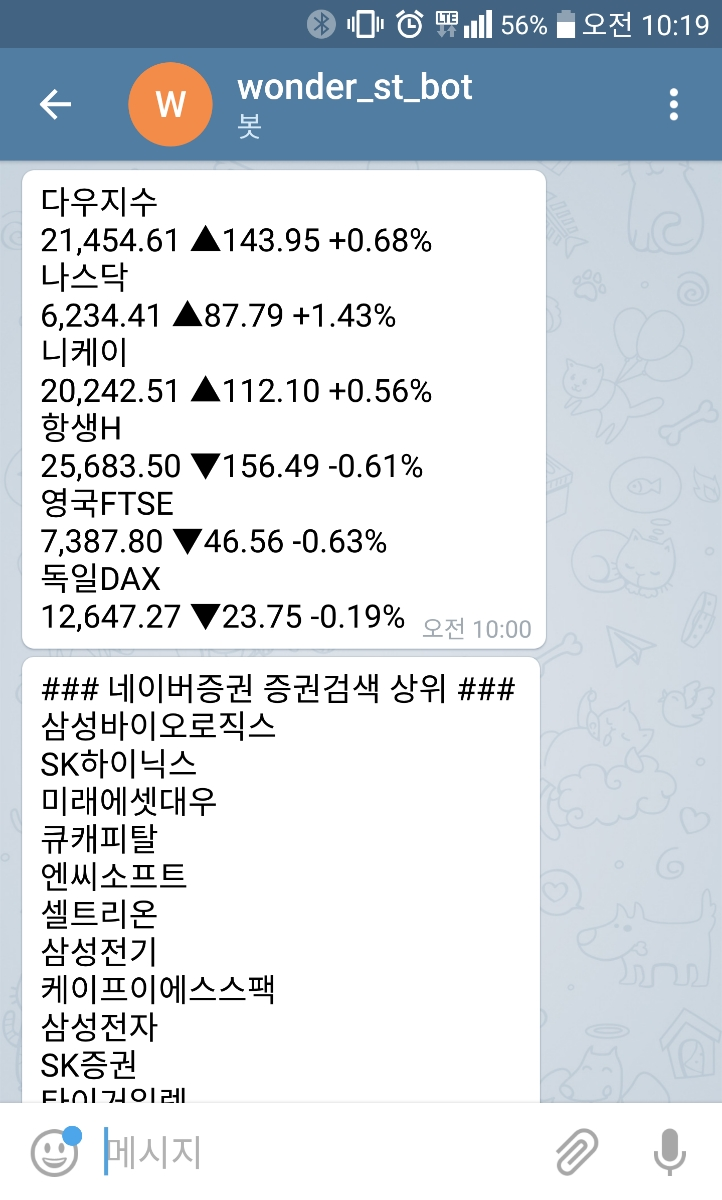

In [14]:
# 발송 메시지 예시
from IPython.display import Image
Image("TELEGRAM_picture.jpg",  width=300)